In [ ]:
#using Revise
using DrWatson
@quickactivate "ABoxWorld"
include(srcdir("ABoxWorld.jl"));

In [2]:

import Statistics: mean
using LinearAlgebra
using Zygote
using CairoMakie
CairoMakie.activate!()
#using GLMakie
#GLMakie.activate!()
using BenchmarkTools

# in ordert to have unblurred pictures
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300

### Nonlocal Boxes

In [3]:

convert_matrixbox_to_nsjoint = wirings.convert_matrixbox_to_nsjoint
convert_nsjoint_to_matrixbox = wirings.convert_nsjoint_to_matrixbox


# Boxes as 2x2x2x2 tensors

MaxMixedBox = nsboxes.reconstructFullJoint(UniformRandomBox((2, 2, 2, 2)))
PR(μ, ν, σ) = nsboxes.reconstructFullJoint(PRBoxesCHSH(;μ=μ, ν=ν, σ=σ))
CanonicalPR = PR(0, 0, 0)
PL(α, γ, β, λ) = nsboxes.reconstructFullJoint(LocalDeterministicBoxesCHSH(;α=α, γ=γ, β=β, λ=λ))
SR = (PL(0,0,0,0) .+ PL(0,1,0,1)) ./ 2
#SR = matrix_to_tensor(non_local_boxes.utils.SR)
#PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
#P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
#P1 = matrix_to_tensor(non_local_boxes.utils.P_1)

#wirings.nb_columns = 100 #TODO: Might need reconstruction of A, B, C and D tensors in wirings.jl file
wirings.update_nb_columns!(100)
m = wirings.nb_columns
#W_BS09 = non_local_boxes.utils.W_BS09(m)

CHSH_score = games.canonical_CHSH_score
#inCHSH(P): return float(non_local_boxes.evaluate.h_flat(P))                    # P is a 2x2x2x2 tensor
CHSHprime_score = games.CHSH_score_generator(-1,1,1,1; batched=false)
#WinCHSHprime(P): return float(non_local_boxes.evaluate.h_prime_flat(P))         # P is a 2x2x2x2 tensor


BoxProduct = wirings.tensorized_boxproduct
reduc_BoxProduct = wirings.reduc_tensorized_boxproduct
BoxProduct_matrices(w::Matrix{<:Real}, matrixbox1::Matrix{Float64}, matrixbox2::Matrix{Float64}) = convert_nsjoint_to_matrixbox(reduc_BoxProduct(w, matrixbox1, matrixbox2))


IC_Bound = Original_IC_Bound()
IC_Bound_LHS(P::Array{Float64, 4}) = conditions.evaluate(IC_Bound, P)
IC_Bound_LHS(W::Matrix{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)
IC_Bound_LHS(W::Vector{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)

IC_MutInfo = games.MutInfo_IC_vanDam_score

IC_objective = IC_MutInfo #IC_Bound_LHS #OR IC_MutInfo -> switch variable



MutInfo_IC_vanDam_score (generic function with 5 methods)

### Projection of a wiring $\mathsf W$ into the constraint set $\mathcal W$

In [11]:
nsboxes.reconstructFullJoint(LocalDeterministicBoxesCHSH(;α=1, γ=1, β=1, λ=1, unsafe=true))

2×2×2×2 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0
 0.0  1.0

[:, :, 2, 1] =
 0.0  1.0
 0.0  0.0

[:, :, 1, 2] =
 0.0  0.0
 1.0  0.0

[:, :, 2, 2] =
 1.0  0.0
 0.0  0.0

### Line Search

Standard reference in Numerical Optimization: https://doi.org/10.1007/b98874

$$
\left\{
\begin{array}{l}
    \alpha^*_k = \argmax_\alpha \phi(x_k + \alpha \nabla \phi(x_k))\\
    x_{k+1}= \texttt{proj}(x_k + \alpha^*_k \nabla \phi(x_k))
\end{array}
\right.
$$

In [4]:

function reorder_list(L::Vector, phi::Vector)
    j=1
    while j <= length(L)
        if j!=1 && phi[L[j-1]]<phi[L[j]]
            L[j-1], L[j] = L[j], L[j-1]
            j-=2
        end
        j+=1
    end
    return L
end


reorder_list (generic function with 1 method)

In [5]:

function select_best_columns(W::Matrix{<:Real}, P::Matrix{Float64}, Q::Matrix{Float64}, selection_size::Int)
    # P,Q are 4x4 matrices; Selection size = number of best columns to keep, others are overwritten by random columns
    if selection_size==0
        return random_wire_matrix(m)
    end
    # L is the list of the "best" indexes of the columns of W
    # At the begining, we take the first indexes of W
    # We will change the list L by comparing the value at the other indexes
    # When we add a term to L, we also remove the "worst" one, and we re-order the list L
    L = [1:selection_size...]
    # phi is the list of values:
    phi= IC_objective(W,P,Q) #TODO: Possibly changed back to non_local_boxes.evaluate.
    # We re-order the list L:
    L = reorder_list(L, phi)
    for i in (selection_size+1):m
        if phi[i]>phi[L[end]]
            L[end]=i # We remove and replace the worst index
            L = reorder_list(L, phi)
        end
    end
    W_new = random_wire_matrix(m) 
    for k in 1:selection_size
        W_new[:,k] = W[:,L[k]] # we keep only the best ones
    end
    return W_new
end

select_best_columns (generic function with 1 method)

In [6]:
function line_search_with_resets(P::Matrix{Float64}, Q::Matrix{Float64}, LS_iterations::Int, K_reset::Int, χ::Float64)
    # P,Q are 4x4 matrices; m is a global variable = wirings.nb_columns
    W, external_grad = zeros(32,m), ones(m)
    Krange, LSrange = 1:K_reset, 1:LS_iterations
    
    for j in 0:Int(1/χ)-1
        # Reset some of the wirings:
        W = select_best_columns(W, P, Q, min(m, Int(j*m*χ)))

        # At the end, we do a lot of steps:
        if j==Int(1/χ)-1
            Krange=1:(10*K_reset)
        end

        # Line search:
        for _ in Krange
            wirings.update_nb_columns!(Int(1e0))
            grad_W = stack(Zygote.gradient(W_vec -> IC_objective(W_vec, P, Q), W[:, b_i])[1] for b_i in 1:size(W)[2])
            wirings.update_nb_columns!(100)
            #grad_W = reshape(transpose(Zygote.jacobian(W -> IC_objective(W, P, Q), W)[1])*external_grad, 32, m)
            
            α = ones(1,m)*0.1
            Gains = IC_objective(W, P, Q)
            Gains_futur = IC_objective(W + (α .*grad_W), P, Q)
            for _ in LSrange
                mask = 0.0 + (Gains>Gains_futur)
                α = 0.8*mask*α + 1.3*(1-mask)*α
                Gains = max(Gains, Gains_futur)
                Gains_futur = IC_objective(W + (α .* grad_W), P, Q)
            end
            W = wirings.projected_wiring(W + (α .* grad_W))
        end
    end
    return W
end

line_search_with_resets (generic function with 1 method)

In [7]:
function Compute_Coeff(P1::Array{Float64,4}, P2::Array{Float64,4}, P3::Array{Float64,4}, alt_G_score_val::Real, CHSH_score_val::Real, alt_Game_score::Function) # P1, P2, P3 are 2x2x2x2 tensors
    A = [alt_Game_score(P1) alt_Game_score(P2) alt_Game_score(P3);
           CHSH_score(P1)     CHSH_score(P2)     CHSH_score(P3);
                1                    1                1           ]
    b = [alt_G_score_val, CHSH_score_val, 1]
    return A \ b # Equiv. to np.linalg.solve(A, b)
end


function is_in_Q(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return conditions.check(NPA_TLM_Criterion(), Box)

    #E_xy = ProbBellCorrelator(Box)
    #coeff00 = asin(E_xy[1,1])
    #coeff01 = asin(E_xy[1,2])
    #coeff10 = asin(E_xy[2,1])
    #coeff11 = asin(E_xy[2,2])
    #return coeff00 + coeff01 + coeff10 - coeff11 <= pi
end

is_in_Q (generic function with 1 method)

In [8]:


function is_in_Pawlowski2009(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function)
    alpha, beta, gamma = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    MixedBox = alpha*Box1 + beta*Box2 + gamma*Box3
    
    #return conditions.check( Correlated_Inputs_IC_Bound(ϵ=0.99), MixedBox, :Q)
    return conditions.check(Original_IC_Bound(), MixedBox, :Q)
    #return conditions.check(Generalized_Original_IC_Bound(), MixedBox, :Q)
end


is_in_Pawlowski2009 (generic function with 1 method)

In [9]:


function is_in_wired_ICBound(P::Array{Float64,4}, max_power::Int, LS_iterations::Int, K_reset::Int, χ::Real, verbose=true)
    # cf. "Algorithm 4" in the article
    # Here we turn the 2x2x2x2 tensors into 4x4 matrices
    P = convert_nsjoint_to_matrixbox(P)
    Pn = P
    for c_pow in 1:max_power
        verbose && println("MutInfo(Pn) = ", IC_MutInfo(convert_matrixbox_to_nsjoint(Pn)), " |-| ", "IC_Bound_LHS(Pn) = ", IC_Bound_LHS(convert_matrixbox_to_nsjoint(Pn)))
        W = line_search_with_resets(Pn, P, LS_iterations, K_reset, χ)
        L = IC_objective(W,Pn,P)
        verbose && (@show c_pow, L)
        verbose && println("max = ", float(maximum(x->isnan(x) ? -Inf : x,L)), "mean = ", float(mean(filter(!isnan,L))), "min = ", float(minimum(x->isnan(x) ? Inf : x,L)))
        W = select_best_columns(W, Pn, P, 1)
        L = IC_objective(W,Pn,P)
        Pn = BoxProduct_matrices(W, Pn, P)

        
        ###
        #Check whether IC is violated (within the van Dam protocol)
        if conditions.check(IC_Bound, convert_matrixbox_to_nsjoint(Pn), :Q)
        #Pn_Biases = 2*(convert_matrixbox_to_nsjoint(Pn).diagonal(offset=0, dim1=0, dim2=1).sum(dim=-1)) - 1. 
        #if sum(square(sum(P_RAC_lossless_vanDam_CHSH .* Pn_Biases, dims=1)), dims=2) > 1. 
            return true
        end
        #if WinCHSH(matrix_to_tensor(Pn))>(3+math.sqrt(6))/6:   return True
    end
    return false
end

is_in_wired_ICBound (generic function with 2 methods)

In [10]:


function draw_IC_violating_boxes(;Box1::Pair{String, Array{Float64,4}}, Box2::Pair{String, Array{Float64,4}}, Box3::Pair{String, Array{Float64,4}}, alt_Game_score::Function, max_power::Int, LS_iterations::Int, K_reset::Int, χ::Float64, precision::Float64=0.001, precisionQ::Float64=1e-4, markersize::Real=4, big::Bool=true, verbose::Bool=false)
    # P, P1, P2, P3 are 2x2x2x2 matrices
    # P1 is the most non-local box
    # P2 is the most local box
    # P3 is the box that is local but scores less in CHSH than P1 (often on boundary of Q set)

    wirings.nb_columns<100 && (@warn "WARNING - Increase the number of columns to at least 100 please (i.e. wirings.nb_columns).")

    P1, P2, P3 = Box1.second, Box2.second, Box3.second

    # Draw the initial background triangle:
    x1, y1 = alt_Game_score(P1), CHSH_score(P1) #Stays CHSH because it's the coordinate system of the plot, also in IC
    x2, y2 = alt_Game_score(P2), CHSH_score(P2)
    x3, y3 = alt_Game_score(P3), CHSH_score(P3)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned (= allow 2D viz.):
    ( (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3) ) && error("We can't make a 2D plot from a 0D or 1D space of points.")
    
    
    # Initialize figure and colors:
    Pawlowski2009_color = :deepskyblue3
    wired_IC_color = :orangered
    NS_color = :black
    Quantum_color = "#e82051"

    fig = Figure(; size=(800,600))
    title_visible = false
    ax = Axis(fig[1, 1]; xlabel = "CHSH'", ylabel = "CHSH", xlabelsize=(big ? 12 : 10), ylabelsize=(big ? 12 : 10),
            #titlevisible=title_visible, titlesize=(big ? 15 : 12.5), title =L"IC Violating Boxes ($K_{{reset}}$=%$(K_reset), χ=%$(χ), m=$10^%$(Int(log10(m)))$, M=%$(LS_iterations), N=%$(max_power)).",
            )
    xlims!(ax, min(x1, x2, x3), max(x1, x2, x3))
    ylims!(ax, min(y1, y2, y3), max(y1, y2, y3))

    text!(ax, Box1.first, position=(x1+0.001, y1), space = :data, align = (:center, :baseline),font = :bold)
    text!(ax, Box2.first, position=(x2, y2-0.007), space = :data, align = (:center, :center),font = :bold)
    text!(ax, Box3.first, position=(x3, y3-0.007), space = :data, align = (:center, :center),font = :bold)

    #Draw the Boundary of the NS set:
    ns_boundary_line = lines!(ax, [x1, x2, x3, x1], [y1, y2, y3, y1]; color=NS_color, linewidth=3)
    #triangle = plt.Polygon(np.array([[x1, y1], [x2,y2], [x3, y3]]), color=NS_color)

    
    # Draw the Quantum area:
    c_alt_G_score_val=min(x2,x3) #Initialize at x-axis origin
    c_CHSH_score_val=4 #Safely initialize at the maximum local value of CHSH
    Quantum_alt_G_scores = Float64[]
    Quantum_CHSH_scores = Float64[]
    while c_alt_G_score_val <= max(x2, x3)
        if is_in_Q(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score)
            push!(Quantum_alt_G_scores, c_alt_G_score_val)
            push!(Quantum_CHSH_scores, c_CHSH_score_val)
            ### Area plot line-by-line: lines!(ax, [c_alt_G_score_val, c_alt_G_score_val], [c_CHSH_score_val, y2], color=Quantum_color) # Draw a vertical line of the Q set
            c_alt_G_score_val+=precisionQ # Go to the next point along x-axis / vertical line 
            #Note that we don't need to re-initialize c_CHSH_score_val, as the convex boundary can only curve downwards anyway
        else #Else we go down along y-axis towards the Q set. 
            if c_CHSH_score_val - precisionQ > y2  #Still on the canvas of our viz.
                c_CHSH_score_val -= precisionQ
            else
                c_CHSH_score_val=y2 #Take the canvas lower-boundary as the quantum boundary (even if it's not in the Q set) 
                c_alt_G_score_val+=precisionQ # Go to the next point along x-axis / vertical line 
            end
        end
    end
    quantum_boundary_line = lines!(ax, Quantum_alt_G_scores, Quantum_CHSH_scores; color=Quantum_color, linewidth=3)
    #plt.plot(0.75, 0.75,'o', markersize=0.7, color=Quantum_color) # Algebraic max. point of CHSH_prime

    
    # Draw the IC violating area [Pawlowski2009]:
    algebraic_max_CHSH_score = 4.0
    min_CHSHprime_score = 0.0
    init_CHSH_guess = 2 #TODO: Might want to adapt this initial y-value further down the y-axis
    c_alt_G_score_val = min(x2,x3) #Reset x-axis pointer to smallest value on the x-axis
    c_CHSH_score_val = init_CHSH_guess 
    Pawlowski2009_alt_G_scores = Float64[]
    Pawlowski2009_CHSH_scores = Float64[]
    while c_alt_G_score_val - min_CHSHprime_score <= algebraic_max_CHSH_score - c_CHSH_score_val  #Check whether still within NS region; equiv. to whether there still is a pair of (G, CHSH) that can be in the NS region
        #@show c_alt_G_score_val, c_CHSH_score_val
        if !is_in_Pawlowski2009(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score)
            push!(Pawlowski2009_alt_G_scores, c_alt_G_score_val)
            push!(Pawlowski2009_CHSH_scores, c_CHSH_score_val)
            ### plt.plot([G_value, G_value], [CHSH_value, (algebraic_max_CHSH+min_CHSH_prime)-G_value], color=Pawlowski2009_color) #Approached from below -> So draw up to (linear) NS boundary
            c_alt_G_score_val += precisionQ # Success, so move on to next point along x-axis
            c_CHSH_score_val = min(y2,y3)*(c_alt_G_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_alt_G_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange (linear?) interpolation on plot origin (0.75, 0.75) and (0.5, init_CHSH_guess) for x-point of next iteration; Set new initial y-value to 
            #Above CHSH guess does not work if boundary happens to be concave! (might guess to high -> too loose boundary)
        else
            #if CHSH_value+precisionQ < (algebraic_max_CHSH): 
            if c_CHSH_score_val + precisionQ < (algebraic_max_CHSH_score-c_alt_G_score_val)
                c_CHSH_score_val += precisionQ #Stay at same x-point, but go up along y-axis
            else #Accept that we're at the boundary of the NS region and move on to the next x-point
                c_alt_G_score_val += precisionQ
                c_CHSH_score_val = min(y2,y3)*(c_alt_G_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_alt_G_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange interpolation; Same as in comment above
            end
        end
    end
    
    pawloski2009_boundary_line = lines!(ax, Pawlowski2009_alt_G_scores, Pawlowski2009_CHSH_scores; color=Pawlowski2009_color, linewidth=3)

    
    
    # Draw the boxes that violate IC after wiring [this work]:
    wired_ICBound_points=[]
    α_max = 0.99
    γ_max = 0.99
    α, γ = 0., 0. #Initial values for box-mixture-coefficients = start with most local box in family of boxes.
    while γ<γ_max && α<α_max
        tmp_α, tmp_γ = round(α; digits=4), round(γ; digits=4) #Temparory, mutable copy of coefficients
        verbose && (@show tmp_α, tmp_γ)
        
        P = tmp_α*P1 + (1-tmp_α-tmp_γ)*P2 + tmp_γ*P3 #Note that P2 is the most local box!
        if is_in_wired_ICBound(P, max_power, LS_iterations, K_reset, χ)
            push!(wired_ICBound_points, (tmp_α, tmp_γ))
            while tmp_α < α_max #When found one point (from below), than all even more non-local boxes also violate IC = iterate through higher alphas
                P = tmp_α*P1 + (1-tmp_α-tmp_γ)*P2 + tmp_γ*P3
                scatter!(ax, [alt_Game_score(P)], [CHSH_score(P)], marker=:circle, markersize=markersize, color=wired_IC_color)
                tmp_α = round(tmp_α + precision; digits=4)
            end
            γ += precision*(3/4) #Move to next gamma = right-wards (equiv. to horizontal axis)
        else
            α += precision #Move to next alpha = higher (equiv. to !vertical! axis)
        end
    end
    
    
    #Misc. plot settings:
    
    legend_visible = true
    legend_visible ? (axislegend(ax, [ns_boundary_line, quantum_boundary_line, pawloski2009_boundary_line, MarkerElement(color = wired_IC_color, marker=:circle, markersize = 15)], 
                    ["NS boundary","Quantum boundary", "Pawloski2009", "IC violating wired boxes"];
                    position = :rt, labelsize = (big ? 10.5 : 9.5) )) : nothing
    
    
    fig # equiv. to plt.show()
    #return precision
end

draw_IC_violating_boxes (generic function with 1 method)

### Examples:

(tmp_α, tmp_γ) = (0.0, 0.0)
MutInfo(Pn) = 7.213595433852582e-5 |-| IC_Bound_LHS(Pn) = 4.0


(c_pow, L) = (1, [7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702735e-5, 7.224688352702


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.224689078100255e-5, 7.22468907810

(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938

(c_pow, L) = (1, [7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315019e-5, 7.224691254315

(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.224694881324822e-5, 7.22469488132


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

(c_pow, L) = (1, [7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129666e-5, 7.224699959129

(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.224706487773958e-5, 7.22470648777

(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.224714467213289e-5, 7.22471446721


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.224723897492069e-5, 7.22472389749

(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

4.0501759999999996
(c_pow, L) = (1, [7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093e-5, 7.224734778588093


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938

(c_pow, L) = (1, [7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501362e-5, 7.224747110501


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.224760893276283e-5, 7.22476089327


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

(c_pow, L) = (1, [7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868449e-5, 7.224776126868

(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.224792811344471e-5, 7.22479281134


(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.23580724386

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

(c_pow, L) = (1, [7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659943e-5, 7.224810946659


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.224830532881477e-5, 7.22483053288

(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.224851569964663e-5, 7.22485156996


(c_pow, L) = (2, [7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.235807243843873e-5, 7.23580724384


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.224874057953912e-5, 7.22487405795

(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

(c_pow, L) = (1, [7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871427e-5, 7.224897996871


(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.23580724386


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938

(c_pow, L) = (1, [7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717208e-5, 7.224923386717

(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

(c_pow, L) = (1, [7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491256e-5, 7.224950227491


(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.23580724386

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.224978519215774e-5, 7.22497851921

(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

(c_pow, L) = (1, [7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935173e-5, 7.225008261935


(c_pow, L) = (2, [7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.235807243866077e-5, 7.23580724386

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.225039455649451e-5, 7.22503945564


(c_pow, L) = (2, [7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.23580724388

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.22507210035861e-5, 7.2250721003586


(c_pow, L) = (2, [7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.23580724388


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.225106196107056e-5, 7.22510619610


(c_pow, L) = (2, [7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.235807243888281e-5, 7.23580724388

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386

(c_pow, L) = (1, [7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894792e-5, 7.225141742894


(c_pow, L) = (2, [7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.23580724391

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.225178740766225e-5, 7.22517874076

(c_pow, L) = (2, [7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938


(c_pow, L) = (1, [7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.225217189721356e-5, 7.22521718972

(c_pow, L) = (2, [7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.225257089782389e-5, 7.22525708978


(c_pow, L) = (2, [7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.23580724391


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938

(c_pow, L) = (1, [7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993733e-5, 7.225298440993


(c_pow, L) = (2, [7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.23580724391


(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.23580914938

(c_pow, L) = (1, [7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377592e-5, 7.225341243377


(c_pow, L) = (2, [7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.235807243910486e-5, 7.23580724391

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.225385496933967e-5, 7.22538549693


(c_pow, L) = (2, [7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.2358072439326

(c_pow, L) = (3, [7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386263e-5, 7.235809149386


(c_pow, L) = (1, [7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.225431201729471e-5, 7.22543120172

(c_pow, L) = (2, [7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408

(c_pow, L) = (1, [7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741899e-5, 7.225478357741


(c_pow, L) = (2, [7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.2358072439326

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408


(c_pow, L) = (1, [7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.225526965037865e-5, 7.22552696503

(c_pow, L) = (2, [7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269e-5, 7.23580724393269


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940

(c_pow, L) = (1, [7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617369e-5, 7.225577023617

(c_pow, L) = (2, [7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408

(c_pow, L) = (1, [7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547024e-5, 7.225628533547


(c_pow, L) = (2, [7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.23580724395


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940

(c_pow, L) = (1, [7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804626e-5, 7.225681494804

(c_pow, L) = (2, [7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940


(c_pow, L) = (1, [7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.225735907456787e-5, 7.22573590745

(c_pow, L) = (2, [7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940

(c_pow, L) = (1, [7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547918e-5, 7.225791771547

(c_pow, L) = (2, [7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954895e-5, 7.235807243954


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940

(c_pow, L) = (1, [7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078018e-5, 7.225849087078


(c_pow, L) = (2, [7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.23580724399

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408


(c_pow, L) = (1, [7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7.2259078541137e-5, 7

(c_pow, L) = (2, [7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977099e-5, 7.235807243977

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408

(c_pow, L) = (1, [7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654965e-5, 7.225968072654

(c_pow, L) = (2, [7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408


(c_pow, L) = (1, [7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.22602974274622e-5, 7.2260297427462


(c_pow, L) = (2, [7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.23580724399

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408


(c_pow, L) = (1, [7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.226092864431877e-5, 7.22609286443

(c_pow, L) = (2, [7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999304e-5, 7.235807243999

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408


(c_pow, L) = (1, [7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.226157437800751e-5, 7.22615743780

(c_pow, L) = (2, [7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940

(c_pow, L) = (1, [7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764025e-5, 7.226223462764

(c_pow, L) = (2, [7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021508e-5, 7.235807244021


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940


(c_pow, L) = (1, [7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.226290939477131e-5, 7.22629093947


(c_pow, L) = (2, [7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.23580724404

(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408


(c_pow, L) = (1, [7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.226359867917864e-5, 7.22635986791


(c_pow, L) = (2, [7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.23580724404


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940


(c_pow, L) = (1, [7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.226430248175042e-5, 7.22643024817

(c_pow, L) = (2, [7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043713e-5, 7.235807244043


(c_pow, L) = (3, [7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.235809149408468e-5, 7.23580914940

Excessive output truncated after 524503 bytes.

(c_pow, L) = 

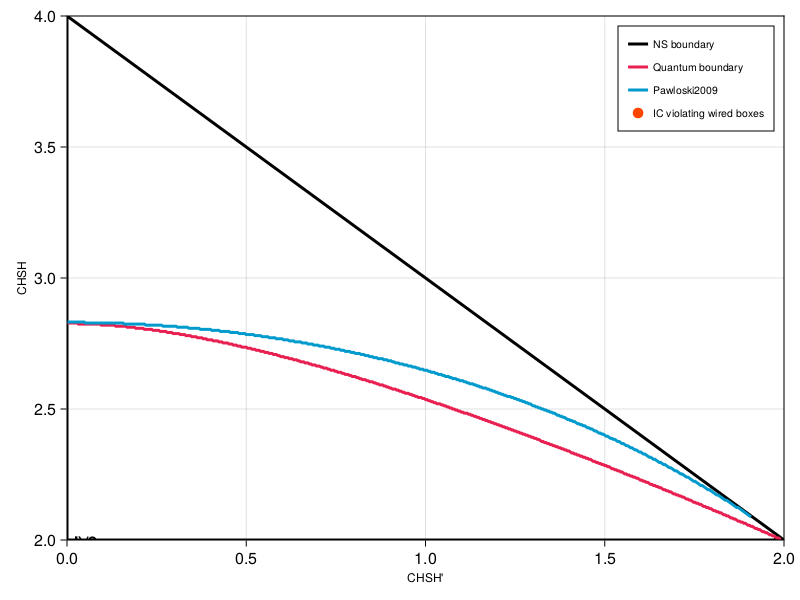

In [13]:
draw_IC_violating_boxes(;
    Box1= "PR"=>CanonicalPR,
    Box2= "SR"=>SR,
    Box3= "(PR+I)/2"=>(CanonicalPR .+ MaxMixedBox) ./ 2,
    alt_Game_score=CHSHprime_score,
    max_power= 3,       # 10
    LS_iterations = 2,  # 20
    K_reset = 2,        # 10
    χ = 0.5,          # 0.1
    precision=1.4e-2,   # 1.4e-2
    precisionQ=4e-3,    # 1e-4
    markersize=2,        #2
    verbose=true
    )
